# L8d: Let's Implement a Cross-Validation Algorithm for Ridge Regression
In this lab, we'll explore how to estimate the optimal regularization parameter for Ridge Regression using cross-validation. Ridge Regression is a type of linear regression that includes a regularization term to prevent overfitting by penalizing large coefficients.

> **Learning objectives:**
>
> In this lab, students will learn to:
>
> * **Generate synthetic datasets for regression testing.** We create a full factorial design with 6 features and 4 levels each, generating all 4,096 possible combinations, then transform this into a log-linear model with known parameters and controlled noise to enable validation of our estimation methods.
> * **Implement k-fold cross-validation for hyperparameter tuning.** We partition training data into k equally-sized folds, systematically train Ridge Regression models on k-1 folds while validating on the remaining fold, and aggregate prediction errors across all folds to estimate generalization performance for different regularization parameters.
> * **Optimize regularization through data-driven parameter selection.** We test δ values across multiple orders of magnitude using cross-validation error as our objective function, identify the optimal regularization strength that minimizes validation error, and compare model performance against arbitrary fixed choices to demonstrate improved prediction accuracy.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on Julia functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include-student.jl"));

  Installing known registries into `C:\Users\billn\.julia`
       Added `General` registry to C:\Users\billn\.julia\registries
    Updating git-repo `https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl.git`
    Updating registry at `C:\Users\billn\.julia\registries\General.toml`
   Resolving package versions...
   Installed BenchmarkTools ─ v1.6.1
   Installed StructUtils ──── v2.5.1
   Installed ArrayInterface ─ v7.21.0
   Installed JSON ─────────── v1.1.0
   Installed ForwardDiff ──── v1.2.2
    Updating `C:\Users\billn\Downloads\CHEM4800\CHEME-5800-Labs-Fall-2025\labs\week-8\L8d\Project.toml`
  [6e4b80f9] + BenchmarkTools v1.6.1
  [a93c6f00] + DataFrames v1.8.0
  [8bb1440f] + DelimitedFiles v1.9.1
  [31c24e10] + Distributions v0.25.122
  [82e4d734] + ImageIO v0.6.9
  [6218d12a] + ImageMagick v1.4.2
  [916415d5] + Images v0.26.2
  [91a5bcdd] + Plots v1.41.1
  [08abe8d2] + PrettyTables v3.1.0
  [10745b16] + Statistics v1.11.1
  [5e47fb64] + TestImages v1.9.0
  [24b7606

In addition to standard Julia libraries, we'll use [`VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material.

### Data
Let's generate some synthetic data that we'll use to train and validate our Ridge Regression model. We'll create a dataset with a known (log) linear relationship and add some noise to it.

> **Full Factorial Design**
>
> Suppose we have 6 features of a product or process we are interested in, each feature can take on 5 discrete levels (1, 2, 3, 4, or 5). We want to generate a dataset that includes all possible combinations of these feature levels. This is known as a full factorial design.
> 
> We'll generate a full factorial design matrix where each feature can take on multiple discrete levels. This creates a structured dataset where we have all possible combinations of feature values. For $p$ features with $\ell$ levels each, this gives us $\ell^p$ total observations.
>
> Our design matrix $\mathbf{D} \in \mathbb{R}^{n \times p}$ will have $n = 5^6 = 15625$ rows (observations) and $p = 6$ columns (features), where each feature takes values in $\{1, 2, 3, 4, 5\}$. This systematic approach ensures we have good coverage of the feature space for testing our regression methods.
> 
> Another fun feature: we can count in base 5 to generate the design matrix!

Let's build the design matrix and store it in the `D::Array{Float64,2}` variable:

In [4]:
D = let

    # initialize -
    number_of_features = 6; # number of features
    number_of_levels = 5; # number of levels per feature
    max_number_of_samples = number_of_levels^number_of_features;
    D = zeros(max_number_of_samples, number_of_features);
    
    # Generate all combinations of features
    base = number_of_levels; # base for number system
    for i in 1:max_number_of_samples
        digits_i = digits(i-1, base=base, pad=number_of_features); # Oooh. This is kind of cool.
        D[i, :] = digits_i; # store the digits    
    end

    D .+= 1 # shift to 1-based min levels
end;

The design matrix `D` contains all possible combinations of feature levels. Each row represents a unique experimental condition, and each column represents one of our 6 features. Let's verify the structure:

In [5]:
D

15625×6 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0
 2.0  1.0  1.0  1.0  1.0  1.0
 3.0  1.0  1.0  1.0  1.0  1.0
 4.0  1.0  1.0  1.0  1.0  1.0
 5.0  1.0  1.0  1.0  1.0  1.0
 1.0  2.0  1.0  1.0  1.0  1.0
 2.0  2.0  1.0  1.0  1.0  1.0
 3.0  2.0  1.0  1.0  1.0  1.0
 4.0  2.0  1.0  1.0  1.0  1.0
 5.0  2.0  1.0  1.0  1.0  1.0
 1.0  3.0  1.0  1.0  1.0  1.0
 2.0  3.0  1.0  1.0  1.0  1.0
 3.0  3.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮
 4.0  3.0  5.0  5.0  5.0  5.0
 5.0  3.0  5.0  5.0  5.0  5.0
 1.0  4.0  5.0  5.0  5.0  5.0
 2.0  4.0  5.0  5.0  5.0  5.0
 3.0  4.0  5.0  5.0  5.0  5.0
 4.0  4.0  5.0  5.0  5.0  5.0
 5.0  4.0  5.0  5.0  5.0  5.0
 1.0  5.0  5.0  5.0  5.0  5.0
 2.0  5.0  5.0  5.0  5.0  5.0
 3.0  5.0  5.0  5.0  5.0  5.0
 4.0  5.0  5.0  5.0  5.0  5.0
 5.0  5.0  5.0  5.0  5.0  5.0

Next, we need to generate the true model parameters that will govern our synthetic data. We'll create:
* An intercept term $\alpha$ that represents the baseline response
* A coefficient vector $\boldsymbol{\gamma} \in \mathbb{R}^{6}$ that represents the effect of each feature

These true parameters will allow us to validate our estimation methods later. We store these in the `α::Float64` and `γ::Array{Float64,1}` variables:

In [6]:
α,γ = let
    
    # initialize -
    α = 2.0; # intercept
    σ = 1.0; # noise level
    number_of_features = size(D, 2);
    γ = 1.0 .+ σ * randn(number_of_features); # coefficients

    (α,γ)
end

(2.0, [1.0373370890198221, 1.8790699632880354, 2.6570427635440623, 0.1506309013179853, -0.15379493943432143, 0.2767328671819268])

Now, let's generate the response variable $\mathbf{y}$ using a log-linear model with additive noise. Our true model has the form:

> **Log-Linear Model with Noise**
>
> The response for observation $i$ is generated as:
> $$\hat{y}_i = \log(\alpha) + \sum_{j=1}^{p} \gamma_j \log(D_{ij}) + \epsilon_i$$
> where $\alpha$ is the intercept, $\boldsymbol{\gamma}$ are the feature coefficients, $\mathbf{D}$ is our design matrix, and $\epsilon_i \sim \mathcal{N}(0, \sigma^2_i)$ is Gaussian noise with observation-specific variance to simulate realistic heteroscedastic measurement error.

We'll store the generated response values in the `ŷ::Array{Float64,1}` variable:

In [7]:
ŷ = let

    # initialize -
    number_of_samples = size(D, 1);
    ŷ = zeros(number_of_samples);
   
    
    # Generate response with some noise
    for i in 1:number_of_samples
        measurement_noise_level = (1+0.25*randn()) |> abs; # noise
        ϵ = Normal(0, measurement_noise_level); # noise distribution
        ŷ[i] = log(α) + dot(γ, log.(D[i, :])) + rand(ϵ); # linear model with noise
    end

    ŷ;
end

15625-element Vector{Float64}:
  1.5795148993377364
  0.45536443453824416
  1.4660249246104966
  2.1026241106880112
  1.4907102445888483
  1.9903008707478163
  1.6880479569190914
  3.7972701861455116
  4.049276702533823
  3.5373607617635376
  0.1498108872629298
  6.283990810832048
  4.1132809059187325
  ⋮
 10.584799305543799
  8.271543717018925
  8.366141385841626
  9.275404981104446
  9.886619668799952
  9.83508889848185
  8.666341356125859
  8.19531414490192
  8.761752220794824
  9.142286542916272
 11.895476871208691
 10.345646857760968

Finally, let's partition the data into a `training` and `testing` set so that we can determine how well the model can predict unseen data, i.e., how well the model generalizes.

In [8]:
training, testing = let

    # initialize -
    s = 0.80; # fraction of data for training
    number_of_training_samples = Int(s * size(D,1) |> floor); # 80% of the data for training
    i = randperm(size(D,1)); # random permutation of the indices
    training_indices = i[1:number_of_training_samples]; # first 80% of the indices
    testing_indices = i[number_of_training_samples+1:end]; # last 20% of
    
    # setup training -
    one_vector = ones(number_of_training_samples);
    training = (X = [log.(D[training_indices, :]) one_vector], y = ŷ[training_indices]);

    # setup testing -
    one_vector = ones(length(testing_indices));
    testing = (X = [log.(D[testing_indices, :]) one_vector], y = ŷ[testing_indices]);
    training, testing;
end;

In [9]:
training.X

12500×7 Matrix{Float64}:
 1.60944   0.693147  0.0       0.0       0.0       0.693147  1.0
 1.60944   0.693147  1.09861   1.60944   1.09861   1.60944   1.0
 0.693147  0.0       1.60944   0.0       1.60944   1.38629   1.0
 0.0       0.0       1.38629   0.693147  1.09861   1.38629   1.0
 1.60944   0.693147  0.693147  0.693147  0.693147  0.0       1.0
 1.38629   1.09861   1.09861   0.693147  1.09861   1.38629   1.0
 0.0       1.09861   1.09861   0.0       0.693147  1.60944   1.0
 0.0       0.693147  1.60944   1.38629   1.09861   0.0       1.0
 0.0       1.38629   1.60944   0.693147  1.60944   1.38629   1.0
 1.60944   1.60944   1.09861   0.693147  1.09861   1.09861   1.0
 1.09861   0.693147  1.60944   0.693147  0.693147  0.693147  1.0
 0.0       1.38629   1.38629   0.0       1.09861   1.60944   1.0
 0.693147  0.0       1.60944   1.60944   0.0       0.693147  1.0
 ⋮                                                 ⋮         
 0.693147  1.38629   1.60944   1.09861   1.60944   0.693147  1.0
 1.

___

## Task 2: Estimate model parameters with Ridge Regression
In this task, we'll estimate the model parameters using Ridge Regression with a fixed regularization parameter. This will give us a baseline to compare against the cross-validation optimized model we'll develop in Task 3.

> **Ridge Regression (L2 Regularization)**
>
> There are several types of regularization techniques, but we will focus on __Ridge regression__ (also known as Tikhonov regularization or L2 regularization). The ridge regression problem is given by:
> $$
\begin{align*}
\hat{\mathbf{\theta}}_{\delta} = \arg\min_{\mathbf{\theta}}\left( \frac{1}{2}\;\lVert~\mathbf{y} - \hat{\mathbf{X}}\;\mathbf{\theta}~\rVert^{2}_{2} + \frac{\delta}{2}\;\lVert~\mathbf{\theta}~\rVert^{2}_{2}\right)
\end{align*}
$$
> where $\delta\geq 0$ is the regularization parameter controlling regularization strength. The first term measures the sum of squared errors, while the second term penalizes large parameter values. The analytical solution for the optimal parameters is given by:
> $$
\begin{align*}
\hat{\mathbf{\theta}}_{\delta} &= \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}} + \delta\;\mathbf{I}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}
\end{align*}
$$
> The regularization parameter $\delta$ controls the trade-off between fitting the data well (small residuals) and keeping parameter magnitudes small (preventing overfitting). When $\delta = 0$, we recover ordinary least squares.

Let's start by setting the regularization parameter `δ::Float64`.

In [10]:
δ = 1000.0; # regularization parameter

Next, let's compute the model parameters directly using the ridge regression formula above. We'll save the model parameters in the `θ̂::Vector{Float64}` variable.

In [11]:
θ̂ = let

    # initialize -
    X = training.X;
    y = training.y;
    p = size(X,2); # number of parameters

    # compute the ridge regression parameters -
    θ_ridge = inv(transpose(X)*X + δ*I(p))*transpose(X)*y;
    θ_ridge; # return
end;

Let's compare our estimated parameters $\hat{\mathbf{\theta}}$ to the true parameters we used to generate the data. We'll create a table showing the true values, estimated values, errors, and relative errors (as percentages):

In [12]:
let 
    
    # initialize -
    df = DataFrame();
    number_of_parameters = length(θ̂);

    # build true parameter vector array -
    θ_true = vcat(γ, log(α));

    # fill the data frame -
    for i ∈ 1:number_of_parameters
        row_df = (
            Parameter = "θ[$i]",
            True = θ_true[i],
            Estimated = θ̂[i],
            Error = θ̂[i] - θ_true[i],
            RelativeErrorPercent = 100 * (θ̂[i] - θ_true[i]) / θ_true[i]
        );
        push!(df, row_df);
    end

    pretty_table(
         df;
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );


end

 ----------- ----------- ----------- ------------ ----------------------
  Parameter        True   Estimated        Error   RelativeErrorPercent 
     String     Float64     Float64      Float64                Float64 
 ----------- ----------- ----------- ------------ ----------------------
       θ[1]     1.03734    0.978138   -0.0591992               -5.70684
       θ[2]     1.87907     1.67585    -0.203223               -10.8151
       θ[3]     2.65704     2.28481     -0.37223               -14.0092
       θ[4]    0.150631    0.282324     0.131693                87.4279
       θ[5]   -0.153795   0.0488224     0.202617               -131.745
       θ[6]    0.276733    0.384847     0.108114                39.0679
       θ[7]    0.693147    0.813065     0.119917                17.3004
 ----------- ----------- ----------- ------------ ----------------------


Now let's visualize the residuals (prediction errors) for the training data. Residuals are the differences between observed and predicted values: $r_i = y_i - \hat{y}_i$. 

> **Why examine residuals?** A good model should have residuals that are randomly scattered around zero with no obvious patterns. Systematic patterns in residuals suggest the model is missing important features or relationships in the data.

So what do the residuals look like for our training data?

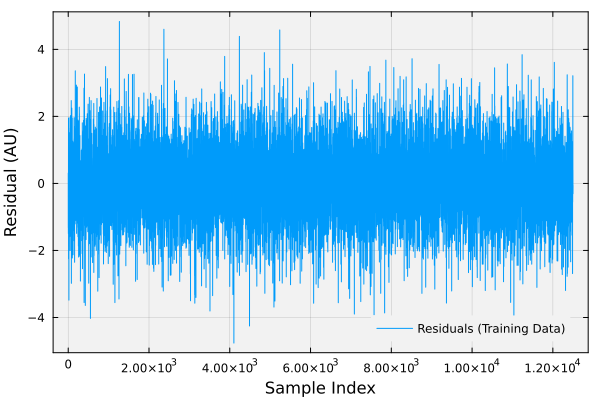

In [13]:
let

    p = vcat(γ, log(α))
    predicted_training_y_reg = training.X * p; # predicted output for the training data
    y_train = training.y;
    r = y_train .- predicted_training_y_reg;
    plot(r, label="Residuals (Training Data)")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Sample Index")
    ylabel!("Residual (AU)")
end

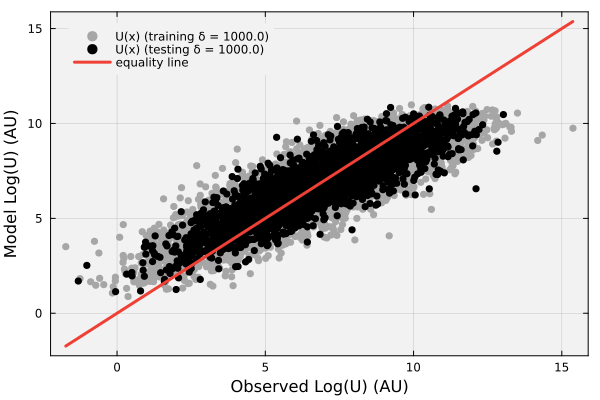

In [12]:
let

    # initialize -
    p = vcat(γ, log(α));
    p = θ̂; # use estimated parameters
    predicted_training_y_reg = training.X * p; # predicted output for the training data
    predicted_testing_y_reg = testing.X * p; # predicted output for the testing data

    # initialize -
    y_train = training.y;
    ŷ_train = predicted_training_y_reg;
    y_test = testing.y;
    ŷ_test = predicted_testing_y_reg;

    dv = [ŷ_train ; y_train ; ŷ_test ; y_test];
    L = minimum(dv);
    U = maximum(dv);
    xy_line = L:0.1:U |> collect; 

    scatter(y_train,ŷ_train,label="U(x) (training δ = $(δ))",c=:gray65, msc=:gray65)
    scatter!(y_test,ŷ_test,label="U(x) (testing δ = $(δ))",c=:black, msc=:black)
    plot!(xy_line,xy_line,lw=3, label="equality line", c=colorant"#EF4035")
    

    xlabel!("Observed Log(U) (AU)", fontsize=18)
    ylabel!("Model Log(U) (AU)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

## Task 3: Cross-Validation to Estimate Optimal Regularization Parameter
In this task, we'll implement a cross-validation algorithm to estimate the optimal regularization parameter `δ`. Cross-validation is a technique used to assess how the results of a statistical analysis will generalize to an independent dataset. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

> **K-Fold Cross-Validation Algorithm - Let's Break It Down**
>
> In **k-fold cross-validation**, we partition the training data $\mathcal{D}_{\text{train}}$ into $k$ equally-sized disjoint subsets (folds) $\mathcal{F}_1, \mathcal{F}_2, \ldots, \mathcal{F}_k$. For each fold $j$:
> 1. Use fold $\mathcal{F}_j$ as the validation set
> 2. Train the model on the remaining $k-1$ folds: $\mathcal{D}_{\text{train}} \setminus \mathcal{F}_j$
> 3. Compute the mean squared error (MSE) on the validation fold $\mathcal{F}_j$
>
> We repeat this process for all $k$ folds and compute the average validation error:
> $$\text{CV}_k(\delta) = \frac{1}{k}\sum_{j=1}^{k} \text{MSE}_j(\delta)$$
> where $\text{MSE}_j(\delta)$ is the mean squared error on fold $j$ for regularization parameter $\delta$.
>
> **The Key Insight**: By testing multiple $\delta$ values and selecting:
> $$\delta^{\star} = \arg\min_{\delta \in \{\delta_1, \ldots, \delta_m\}} \text{CV}_k(\delta)$$
> we find the regularization strength that **generalizes best** to unseen data, balancing bias (underfitting) and variance (overfitting).
>
> **Our Implementation Strategy**:
> - **Outer loop**: Test each δ value in `δ_values`
> - **Inner loop**: For each δ, perform k-fold cross-validation
>   - For each fold: designate it as validation, train on the rest
>   - Compute MSE on validation fold
> - **Storage**: Keep track of mean and std of MSE for each δ
> - **Selection**: Choose δ that minimizes CV error

Let's implement this algorithm step by step.

### Step 1: Define Candidate Regularization Parameters

First, let's define the range of regularization parameters we want to test. We'll use a logarithmic scale to cover several orders of magnitude, from very weak regularization ($\delta = 10^{-3}$) to very strong regularization ($\delta = 10^{3}$):

> **Why logarithmic scale?**
> - Ridge regression is sensitive to δ across many orders of magnitude
> - A linear scale would waste computation on similar values
> - Log scale gives us uniform coverage of the regularization spectrum
> - 101 values spread across 6 orders of magnitude gives good resolution

Let's create our candidate δ values:

In [14]:
δ_values = 10.0 .^ range(-3, 3, length=101); # test δ from 0.001 to 1000

### Step 2: Implement K-Fold Cross-Validation

Now, let's implement the k-fold cross-validation algorithm. For each candidate $\delta$ value, we'll:
1. Randomly shuffle and partition the training data into `k = 100` folds
2. For each fold, train on the other $k-1$ folds and validate on the held-out fold
3. Compute the mean squared error (MSE) for each validation fold
4. Store the mean and standard deviation of MSE across all folds

We'll save the results in the `cv_results` named tuple:

In [18]:
cv_results = let

    # TODO: Complete this cross-validation implementation
    # Step 1: Extract training data
    X_train = training.X;
    y_train = training.y;
    n_samples = size(X_train, 1);
    n_params = size(X_train, 2);
    k = 20; # number of folds (we can change this!)
    
    # Step 2: Shuffle the indices for random fold assignment
    shuffled_indices = randperm(n_samples);
    fold_size = div(n_samples, k);
    
    # Step 3: Initialize storage for results
    # TODO: Create arrays to store mean and std of CV errors for each δ
    mean_cv_errors = zeros(length(δ_values)); 
    std_cv_errors = zeros(length(δ_values)); 
    
    # Step 4: Loop over each regularization parameter δ
    for (idx, δ_test) in enumerate(δ_values)
        
        # Store MSE for each fold
        fold_errors = zeros(k);
        
        # Step 5: Perform k-fold cross-validation for this δ
        # TODO: Complete the loop below by:
        #   - Defining validation indices for each fold
        #   - Creating training indices (everything except validation)
        #   - Training a ridge model on fold training data
        #   - Making predictions on validation data
        #   - Computing MSE for the validation fold
        
        for fold ∈ 1:k
            # Define validation indices for this fold
            val_start = (fold - 1) * fold_size + 1;
            val_end = (fold == k) ? n_samples : fold * fold_size;
            val_indices = shuffled_indices[val_start:val_end];
            
            # Training indices are all indices except validation
            train_indices = setdiff(shuffled_indices, val_indices);
            
            # Split data
            X_fold_train = X_train[train_indices, :];
            y_fold_train = y_train[train_indices];
            X_fold_val = X_train[val_indices, :];
            y_fold_val = y_train[val_indices];
            
            # TODO: Train ridge regression model on this fold
            # Hint: Use the ridge regression formula with δ_test
            θ_fold = inv(transpose(X_fold_train) * X_fold_train + δ_test * I(n_params)) * 
                     transpose(X_fold_train) * y_fold_train;
            
            # TODO: Predict on validation set
            y_fold_pred = X_fold_val * θ_fold;
            
            # TODO: Compute MSE for this fold
            fold_errors[fold] = mean((y_fold_val .- y_fold_pred).^2);
        end
        
        # TODO: Store mean and std of CV errors for this δ
        mean_cv_errors[idx] = mean(fold_errors);
        std_cv_errors[idx] = std(fold_errors);
    end
    
    # Return results as a named tuple
    (δ_values = δ_values, mean_errors = mean_cv_errors, std_errors = std_cv_errors);
end;

Now let's identify the optimal regularization parameter $\delta^{\star}$ - the value that minimizes the average cross-validation error. We'll store this in the `δ_optimal::Float64` variable:

In [20]:
δ_optimal = let
    
    # TODO: Find the index of minimum CV error
    min_idx = argmin(cv_results.mean_errors);
    
    # TODO: Extract the optimal δ value
    δ_opt = cv_results.δ_values[min_idx];
    
    # Display results
    println("Optimal regularization parameter: δ = $(round(δ_opt, digits=4))");
    println("Minimum CV error: $(round(cv_results.mean_errors[min_idx], digits=6))");
    
    # Reflection question:
    # - How does this optimal δ compare to our original fixed δ = 1000.0?
    # - Why might the cross-validation selected value be different?
    
    δ_opt;
end;

Optimal regularization parameter: δ = 1.9953
Minimum CV error: 1.056497


### Step 3: Visualize and Interpret the CV Curve

Let's visualize how the cross-validation error changes as a function of the regularization parameter $\delta$. This plot will help us understand the bias-variance trade-off:

> **Interpreting the CV Error Curve**
>
> * **Left side (small $\delta$)**: Weak regularization allows the model to fit training data very closely. This can lead to **overfitting** - the model learns noise along with signal, resulting in high variance and poor generalization (high validation error).
> * **Minimum point**: The optimal $\delta^{\star}$ that balances fitting the data well and regularizing parameters. This is the "sweet spot."
> * **Right side (large $\delta$)**: Strong regularization severely constrains parameters. This prevents the model from capturing true relationships in the data, resulting in **underfitting** - high bias and poor training fit (high validation error).
>
> The shaded region shows the standard deviation across folds. This tells us about the stability of our error estimates. If the ribbon is narrow, the error is consistent across folds; if it's wide, different folds give very different errors.

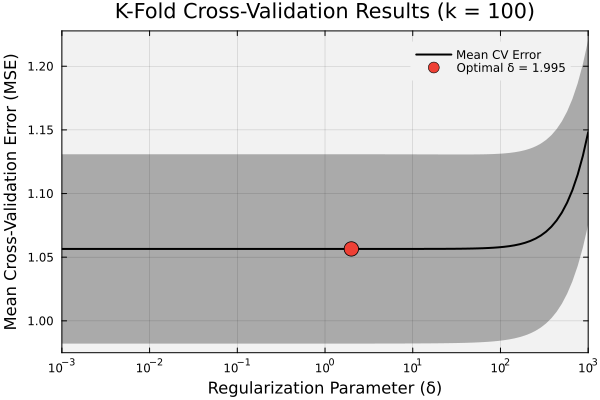

In [21]:
let
    
    # TODO: Create a visualization showing CV error vs regularization parameter
    # The plot should include:
    #   - Mean CV error on a log scale (x-axis is δ)
    #   - A ribbon showing standard deviation across folds
    #   - A marker indicating the optimal δ
    
    plot(cv_results.δ_values, cv_results.mean_errors, 
         xscale=:log10, 
         label="Mean CV Error",
         lw=2, 
         c=:black,
         ribbon=cv_results.std_errors,
         fillalpha=0.3, 
         xlims=(minimum(δ_values), maximum(δ_values)))
    
    # Mark the optimal δ
    scatter!([δ_optimal], [cv_results.mean_errors[argmin(cv_results.mean_errors)]], 
             label="Optimal δ = $(round(δ_optimal, digits=3))",
             c=colorant"#EF4035",
             ms=8,
             markerstroke=2)
    
    xlabel!("Regularization Parameter (δ)", fontsize=14)
    ylabel!("Mean Cross-Validation Error (MSE)", fontsize=14)
    title!("K-Fold Cross-Validation Results (k = 100)")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
end

### Step 4: Train Final Model and Compare Approaches

Now that we've identified the optimal regularization parameter $\delta^{\star}$, let's train a final model on the entire training set and evaluate its performance. 

We'll store the optimal model parameters in the `θ̂_optimal::Vector{Float64}` variable:

In [22]:
θ̂_optimal = let

    # TODO: Train ridge regression model using the optimal δ
    # This should follow the same pattern as the initial ridge regression
    # but use δ_optimal instead of the fixed δ = 1000.0
    
    X = training.X;
    y = training.y;
    p = size(X,2); # number of parameters

    # Use the ridge regression formula with optimal δ
    θ_ridge_optimal = inv(transpose(X)*X + δ_optimal*I(p))*transpose(X)*y;
    θ_ridge_optimal; # return
end;

### Parameter Estimation Comparison

Let's compare the parameters estimated with the optimal `δ` to the true parameters and the parameters we estimated earlier with `δ = 1000.0`. This table shows the true values, estimated values, errors, and relative errors (as percentages). Look for patterns - which approach (fixed vs optimal δ) gets closer to the truth?

In [23]:
let 
    
    # TODO: Create a comparison table showing:
    #   - True parameters (ground truth)
    #   - Parameters estimated with fixed δ
    #   - Parameters estimated with optimal δ
    #   - Errors and relative errors for both approaches
    
    df = DataFrame();
    number_of_parameters = length(θ̂_optimal);

    # Build true parameter vector
    θ_true = vcat(γ, log(α));

    # Fill the data frame
    for i ∈ 1:number_of_parameters
        row_df = (
            Parameter = "θ[$i]",
            True = θ_true[i],
            EstimatedδFixed = θ̂[i],
            EstimatedδOptimal = θ̂_optimal[i],
            ErrorFixed = θ̂[i] - θ_true[i],
            ErrorOptimal = θ̂_optimal[i] - θ_true[i]
        );
        push!(df, row_df);
    end

    pretty_table(
         df;
         backend = :text,
         fit_table_in_display_horizontally = false,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
    
    # Reflection questions:
    # 1. Which approach (fixed δ vs optimal δ) produces smaller errors overall?
    # 2. Are there specific parameters where one approach is better than the other?
end

 ----------- ----------- ----------------- ------------------- ------------ --------------
  Parameter        True   EstimatedδFixed   EstimatedδOptimal   ErrorFixed   ErrorOptimal 
     String     Float64           Float64             Float64      Float64        Float64 
 ----------- ----------- ----------------- ------------------- ------------ --------------
       θ[1]     1.03734          0.978138             1.02558   -0.0591992     -0.0117541
       θ[2]     1.87907           1.67585             1.89925    -0.203223      0.0201767
       θ[3]     2.65704           2.28481             2.65744     -0.37223    0.000394478
       θ[4]    0.150631          0.282324            0.163629     0.131693      0.0129984
       θ[5]   -0.153795         0.0488224           -0.134802     0.202617      0.0189927
       θ[6]    0.276733          0.384847            0.288474     0.108114      0.0117415
       θ[7]    0.693147          0.813065            0.644352     0.119917     -0.0487949
 -----

### Visualization of Model Performance

Finally, let's visualize the predictions using the optimal `δ` and compare them to our earlier results. 
Points closer to the red line = better predictions. The test set performance (black points) is most important because it tells us how well our model generalizes.

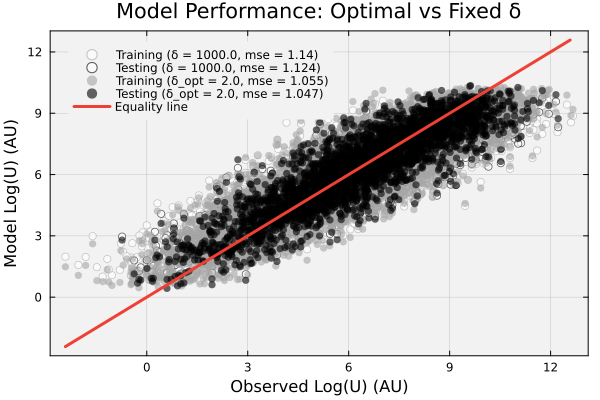

In [24]:
let

    # TODO: Create a comprehensive visualization comparing model performance
    # Make predictions using both approaches
    predicted_training_y_optimal = training.X * θ̂_optimal; 
    predicted_testing_y_optimal = testing.X * θ̂_optimal; 
    predicted_training_y_fixed = training.X * θ̂;
    predicted_testing_y_fixed = testing.X * θ̂;

    Ntrain = length(training.y);
    Ntest = length(testing.y);

    # Data vectors
    y_train = training.y;
    ŷ_train_opt = predicted_training_y_optimal;
    ŷ_train_fixed = predicted_training_y_fixed;
    y_test = testing.y;
    ŷ_test_opt = predicted_testing_y_optimal;
    ŷ_test_fixed = predicted_testing_y_fixed;

    # Compute variance-based performance metrics
    Var_R2_train_opt = sum(((1/Ntrain)*(y_train .- ŷ_train_opt).^2));
    Var_R2_test_opt = sum(((1/Ntest)*(y_test .- ŷ_test_opt).^2));
    Var_R2_train_fixed = sum(((1/Ntrain)*(y_train .- ŷ_train_fixed).^2));
    Var_R2_test_fixed = sum(((1/Ntest)*(y_test .- ŷ_test_fixed).^2));

    # Set axis limits
    dv = [ŷ_train_opt ; y_train ; ŷ_test_opt ; y_test];
    L = minimum(dv);
    U = maximum(dv);
    xy_line = L:0.1:U |> collect; 

    # TODO: Add scatter plots for both models
    # Plot fixed δ predictions (hollow markers)
    scatter(y_train, ŷ_train_fixed, 
            label="Training (δ = $(δ), mse = $(round(Var_R2_train_fixed, digits=3)))",
            c=:white, msc=:gray65, alpha=0.6)
    scatter!(y_test, ŷ_test_fixed, 
             label="Testing (δ = $(δ), mse = $(round(Var_R2_test_fixed, digits=3)))",
            c=:white, msc=:black, alpha=0.6)

    # Plot optimal δ predictions (filled markers)
    scatter!(y_train, ŷ_train_opt, 
            label="Training (δ_opt = $(round(δ_optimal, digits=2)), mse = $(round(Var_R2_train_opt, digits=3)))",
            c=:gray65, msc=:gray65, alpha=0.6)
    scatter!(y_test, ŷ_test_opt, 
             label="Testing (δ_opt = $(round(δ_optimal, digits=2)), mse = $(round(Var_R2_test_opt, digits=3)))",
             c=:black, msc=:black, alpha=0.6)
    
    # Add reference line
    plot!(xy_line, xy_line, lw=3, label="Equality line", c=colorant"#EF4035")
    
    xlabel!("Observed Log(U) (AU)", fontsize=14)
    ylabel!("Model Log(U) (AU)", fontsize=14)
    title!("Model Performance: Optimal vs Fixed δ")
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, 
          fg_legend = :transparent, legend=:topleft, legendfontsize=8)
    
    # Reflection questions:
    # 1. Do points cluster closer to the equality line with optimal δ?
    # 2. Is there a difference in test set performance (black points)?
    # 3. What does this tell us about the generalization of our model?
end

___
## Summary
In this lab, we implemented k-fold cross-validation to estimate the optimal regularization parameter for Ridge Regression. We systematically tested different values of `δ` to find the one that minimizes prediction error on held-out validation data.

> **Key takeaways:**
> * **Cross-validation prevents overfitting through systematic validation.** We implemented k-fold cross-validation to split training data into multiple folds, training on k-1 folds and validating on the remaining fold to estimate generalization error for each regularization parameter.
> * **Optimal regularization balances bias and variance.** By testing δ values across several orders of magnitude and selecting the one with minimum cross-validation error, we found the sweet spot that neither underfits (too much regularization) nor overfits (too little regularization).
> * **Data-driven hyperparameter selection improves model performance.** The cross-validation approach identified an optimal δ that produced better parameter estimates and prediction accuracy compared to an arbitrary fixed choice, as demonstrated by improved R² scores on the test set.

__Where do we go from here?__ Cross-validation is a fundamental technique in machine learning that extends beyond Ridge Regression. The same approach can be used to tune hyperparameters for other regularization methods (Lasso, Elastic Net), neural networks, or any model with tunable parameters. Advanced variations like stratified k-fold, leave-one-out, or nested cross-validation provide even more robust performance estimation for different scenarios.
___